In [2]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import keras
# from mode.config import *
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras import backend as K
import pickle
from PIL import Image
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from matplotlib import pyplot as plt
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore


In [22]:
with open('train.pickle', 'rb') as f:
    X, y = pickle.load(f)






In [23]:
#Convert to np.array
from sklearn.model_selection import train_test_split

X = np.array(X)
y = np.array(y)
X=X[:100, :,:]
y=y[:100, :,:]
y = tf.keras.utils.to_categorical(y, 6)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# y_train = tf.keras.utils.to_categorical(y_train, 6)
# y_test = tf.keras.utils.to_categorical(y_test, 6)


In [43]:
X=X_test[:1, :,:]
X.shape
X=np.moveaxis(X, 0, -1)
X.shape

(512, 512, 1)

In [ ]:
# smooth = 1.

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# def dice_loss(y_true, y_pred):
#   y_true = tf.cast(y_true, tf.float32)
#   y_pred = tf.math.softmax(y_pred)
#   numerator = 2 * tf.reduce_sum(y_true * y_pred)
#   denominator = tf.reduce_sum(y_true + y_pred)

#   return 1 - numerator / denominator

# path_to_model = '/Users/salvatoreesposito/Desktop/AttXnet_1/'
# model = tf.keras.models.load_model(path_to_model, custom_objects={'dice_loss':dice_loss, "dice_coef":dice_coef})



In [24]:
from keras_unet_collection import models, utils

model = models.att_unet_2d((512, 512, 1), filter_num=[64, 128, 256, 512, 1024], n_labels=6, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone=None, weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

model.summary()

In [25]:
print(model.summary())

Model: "attunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
attunet_down0_0 (Conv2D)        (None, 512, 512, 64) 576         input_2[0][0]                    
__________________________________________________________________________________________________
attunet_down0_0_bn (BatchNormal (None, 512, 512, 64) 256         attunet_down0_0[0][0]            
__________________________________________________________________________________________________
attunet_down0_0_activation (ReL (None, 512, 512, 64) 0           attunet_down0_0_bn[0][0]         
______________________________________________________________________________________

In [26]:
def dice_coef(y_true, y_pred, const=K.epsilon()):
    '''
    Sørensen–Dice coefficient for 2-d samples.
    
    Input
    ----------
        y_true, y_pred: predicted outputs and targets.
        const: a constant that smooths the loss gradient and reduces numerical instabilities.
        
    '''
    
    # flatten 2-d tensors
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])
    
    # get true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    
    # 2TP/(2TP+FP+FN) == 2TP/()
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    
    return coef_val



def dice(y_true, y_pred, const=K.epsilon()):

    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    # <--- squeeze-out length-1 dimensions.
    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    loss_val = 1 - dice_coef(y_true, y_pred, const=const)

    return loss_val

In [27]:
model.compile(loss=dice, optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), metrics=dice_coef)
history=model.fit(X_train, y_train, validation_split=0.2, epochs=1, batch_size=1, verbose=1)

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict([X])


In [ ]:
import matplotlib.pyplot as plt

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

IndexError: index 1 is out of bounds for axis 0 with size 1

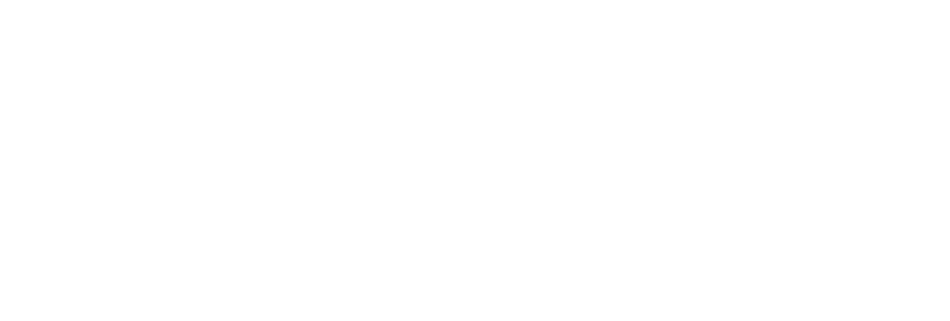

In [21]:
i_sample = 1

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(X[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14)
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14)
AX[2].set_title("Labeled truth", fontsize=14)